# **Dynamical learning of dynamics**
Christian Klos, Yaroslav Felipe Kalle Kossio, Sven Goedeke, Aditya Gilra, and Raoul-Martin Memmesheimer

*Neural Network Dynamics and Computation, Institute of Genetics, University of Bonn, Bonn, Germany.*

---

This notebook contains example code to create a network that dynamically learns sinusoidal oscillations with previously unseen period (task (i) in the paper), without changing its weights. See our **[preprint](https://arxiv.org/abs/1902.02875)** for further details and applications.

# Import dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# Parameters and functions

Parameter | Symbol in the paper | Explanation
--- | --- | ---
`dt` | $dt$ | Integration time step
`N` | $N$ | Size of the reservoir
`N_z` | $N_z$ | Number of signals
`N_c` | $N_c$ | Number of contexts
`p` | $p$ | Connection probability
`g` | $g$ | Scaling of recurrent weights
`w_tilde` | $\tilde{w}$ | Scaling of external weights
`b_tilde` | - | Scaling of biases
`tau` | $\tau$ | Time constant
`t_stay` | $t_\text{stay}$ | Time until target is switched
`t_wlearn` | $t_\text{wlearn}$ | Total pretraining time
`t_fb` | $t_\text{fb}$ | Time the error feedback is provided to network
`RLS_prob` | - | Mean number of weight updates per unit time (probability of weight updates)
`alpha` | $\alpha$ | Inverse of learning rate parameter
`t_learn` | $t_\text{learn}$ | Dynamical learning time
`t_test` | $t_\text{test}$ | Testing time
`tau_forget` | $\tau_\text{forget}$ | Context averaging time constant

In [ ]:
dt = 0.1            # Integration time step

N = 500             # Size of the reservoir
N_z = 1             # Number of signals
N_c = 1             # Number of contexts
p = .1              # Connection probability
g = 1.5             # Scaling of recurrent weights
w_tilde = 1.        # Scaling of external weights
b_tilde = .2        # Scaling of biases
tau = 1.            # Time constant

t_stay = 500        # Time until target is switched
t_wlearn = 5_000    # Total pretraining time

t_fb = 100          # Time the error feedback is provided to network
RLS_prob = 2        # Mean number of weight updates per unit time (probability of weight updates)
alpha = 1           # Inverse of learning rate parameter

t_learn = 50        # Dynamical learning time
t_test = 1_000      # Testing time
tau_forget = 5      # Context averaging time constant

## Reservoir

In [ ]:
def weights_initialize():  
    return {
        'A'     : g/np.sqrt(p*N) * np.random.randn(N,N) * np.random.binomial(1, p, (N, N)),
        'o_z'   : np.zeros((N_z, N)),
        'o_c'   : np.zeros((N_c, N)),
        'w_z'   : np.random.uniform(-w_tilde, w_tilde, (N, N_z)),
        'w_c'   : np.random.uniform(-w_tilde, w_tilde, (N, N_c)),
        'w_eps' : np.random.uniform(-w_tilde, w_tilde, (N, N_z)),
        'b'     : np.random.uniform(-b_tilde, b_tilde, N) }
    
def states_initialize(weights):  
    states = {
        'x'   : np.random.randn(N),
        'eps' : np.zeros(N_z) }

    states['r'] = np.tanh(states['x'] + weights['b'])
    states['z'] = weights['o_z'] @ states['r']
    states['c'] = weights['o_c'] @ states['r']
  
    return states

## Targets

In [ ]:
# The network is trained on a family of sinusoidal oscillations with
# variable periods and constant amplitude

# Target family
def tar_func(tar_period, t):
    return np.array([5 * np.sin(2*np.pi*t/tar_period)])

# The context signal is a linear transformation of the period
def tar_cont(tar_period):
    return 1 + tar_period/10

# Creates the target signal. Arguments are the total time, 
# the time until a target is switched, and an array of the target periods.
def make_targets(time_total, time_per_target, targets_list):
    times = np.arange(0, time_total, time_per_target)
    
    targets = np.zeros(times.shape, dtype = int)
    last = np.array([])
    for i in range(len(targets)):
        tar = np.random.choice(np.setdiff1d(targets_list, last))
        last = np.array([tar])
        targets[i] = tar

    steps_per_target = int(time_per_target/dt)
    steps_total = int(time_total/dt)

    z_tilde = np.zeros((N_z, steps_total+1))
    c_tilde = np.zeros((N_c, steps_total+1))
    
    # The signal should have no jumps when targets are switched
    phases = np.array([(time_per_target/tar)%1 for tar in targets])
    phases[-1] = 0.
    phases = np.roll(phases,1)
    phases = np.cumsum(phases)
    offset_times = phases * targets

    duration = np.linspace(0, time_per_target-dt, steps_per_target)
    
    for i, tar in enumerate(targets):
        index = np.arange(i*steps_per_target+1,(i+1)*steps_per_target+1)
            
        z_tilde[:, index] = (tar_func(tar, offset_times[i] + duration))
        c_tilde[:, index] = tar_cont(tar)
    
    return z_tilde, c_tilde

## Pretraining

In [ ]:
# Initialization of P matrix
def RLS_init():
    return 1/alpha * np.eye(N)

# Recursive least squares algorithm
def RLS(o_z, o_c, r, error_z, error_c, P):
    # Changes non-local variables in-place

    # Update P
    Pr = P @ r
    a = 1 / (1 + np.dot(r, Pr))
    P -= np.outer(Pr, Pr) * a

    # Update output weights
    o_z -= a * np.outer(error_z, Pr)
    o_c -= a * np.outer(error_c, Pr)

## Dynamics 

In [ ]:
def rnn(weights, states, tars, time, pretraining = True, t_learn = None):
    
    # Steps
    steps = int(time/dt)
    step = 0
    
    # Unpack weights
    A = weights['A'].copy()
    o_z = weights['o_z'].copy()
    o_c = weights['o_c'].copy()
    w_z = weights['w_z'].copy()
    w_c = weights['w_c'].copy()
    w_eps = weights['w_eps'].copy()
    b = weights['b'].copy()
    
    # Unpack states
    x = states['x'].copy()
    r = states['r'].copy()
    z = states['z'].copy()
    c = states['c'].copy()
    eps = states['eps'].copy()
    
    # Recording 
    states_rec = { 
        'z'   : np.zeros((N_z, steps+1)),
        'c'   : np.zeros((N_c, steps+1)),
        'eps' : np.zeros((N_z, steps+1)) }

    states_rec['z'][:, step] = z
    states_rec['c'][:, step] = c
    states_rec['eps'][:, step] = eps
    
    # Initialize pretraining algorithms and context averaging
    if pretraining:
        P = RLS_init()
    else:
        c_fix = c.copy()
    
    # Run network
    for step in range(1, steps+1):
        
        # Time
        t = step * dt
        
        # Targets
        z_tilde, c_tilde = tars[0][:, step], tars[1][:, step]
        
        # Simulate one time step
        x += dt * (- x + A @ r + w_eps @ eps + w_z @ z + w_c @ c) / tau
        r = np.tanh(x + b)
        z = o_z @ r
        c = o_c @ r
        eps = z - z_tilde
        
        # Pretraining and testing specific computations
        if pretraining:        
            # Update weights
            if np.random.rand() < RLS_prob * dt:
                RLS(o_z, o_c, r, eps, c-c_tilde, P)

            if (t-dt)%t_stay >= t_fb:
                # Zero error input
                eps = np.zeros(N_z)
                # Fix context signal
                c_nofix = c.copy()
                c = c_tilde.copy()
  
        else:      
            if t >= t_learn:
                # Zero error input
                eps = np.zeros(N_z) 
                # Fix context signal
                c_nofix = c.copy()
                c = c_fix
            else:
                c_fix += dt/tau_forget * (-c_fix + c)
    
        # Recording
        states_rec['z'][:, step] = z
        states_rec['c'][:, step] = c
        states_rec['eps'][:, step] = eps
    
    # Final weights
    weights_final = copy.deepcopy(weights)
    weights_final['o_z'] = o_z
    weights_final['o_c'] = o_c
    
    # Final network state
    states_final = {'x' : x, 'r' : r, 'z' : z, 'c' : c, 'eps' : eps}

    return weights_final, states_final, states_rec

# Pretraining
We pretrain the network on three sines with different periods. You can get good results even if each of the targets is only presented once to the network. 

<img style="float: left;" src="https://raw.githubusercontent.com/chklos/dynamical-learning/master/images/pretraining.png" width="200">

In [ ]:
# Initializing network
weights_init = weights_initialize()
states_init = states_initialize(weights_init)

# Creating pretraining signals: three sinusoidal oscillations with different periods
pretrain_periods = np.array([10, 15, 20]) 
tars_pretrain = make_targets(t_wlearn, t_stay, pretrain_periods)

# Pretraining network
weights_pretrain, states_pretrain, states_pretrain_rec = rnn(
    weights_init, states_init, tars_pretrain, t_wlearn)

Let's plot how the pretraining looks like in practice. As in the paper, $\tilde{z}$ and $\tilde{c}$ are the targets for the signal $z$ and context $c$, respectively.

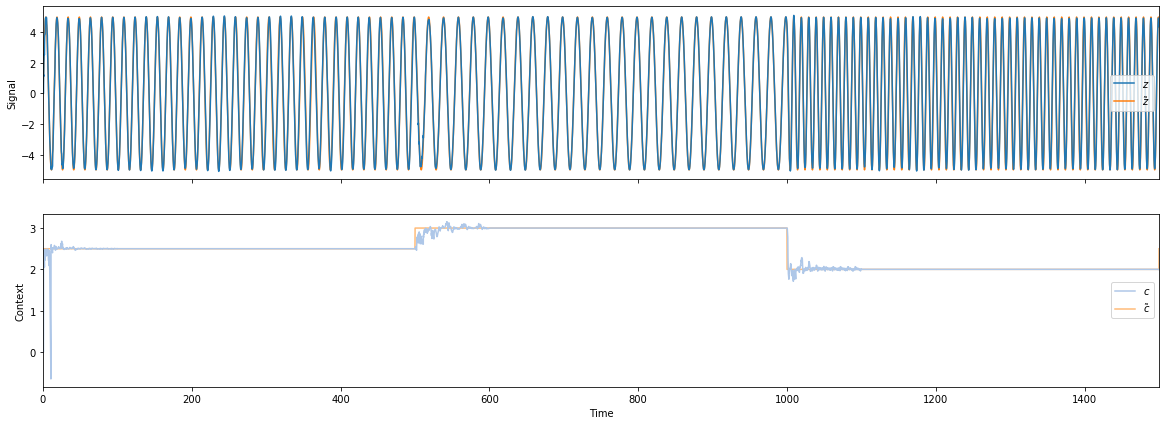

In [ ]:
cmap = plt.get_cmap('tab20')

fig, axs = plt.subplots(2, 1, figsize=(20,7), sharex=True)

pretrain_times = np.linspace(0, t_wlearn, int(t_wlearn/dt)+1)
axs[0].plot(pretrain_times, states_pretrain_rec['z'][0], label='$z$', c=cmap(0), zorder=1)
axs[0].plot(pretrain_times, tars_pretrain[0][0], label=r'$\tilde{z}$', c=cmap(2), zorder=0)
axs[0].legend(loc='right').set_zorder(100)
axs[0].set_xlim(0, 3 * t_stay)
axs[0].set_ylabel('Signal')

axs[1].plot(pretrain_times, states_pretrain_rec['c'][0], label='$c$', c=cmap(1), zorder=1)
axs[1].plot(pretrain_times, tars_pretrain[1][0], label=r'$\tilde{c}$', c=cmap(3), zorder=0)
axs[1].legend(loc='right').set_zorder(100)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Context')

plt.show()

# Dynamical learning and testing
The pretrained network is now able to dynamically, i.e., with fixed weights, learn a sine with previously unseen period.

<img style="float: left;" src="https://raw.githubusercontent.com/chklos/dynamical-learning/master/images/dynlearntesting.png" width="200">

In [ ]:
# Creating a signal for dynamical learning and testing
learntest_t = t_learn + t_test
learntest_period = np.array([12.5])
tars_learntest = make_targets(learntest_t, learntest_t, learntest_period)

# Dynamically learning and testing target
weights_learntest, states_learntest, states_learntest_rec = rnn(
    weights_pretrain, states_pretrain, tars_learntest, learntest_t, pretraining=False, t_learn=t_learn)

Let's look at the dynamical learning. Below, in the left panel, you can see that the signal quickly converges to the target sine and the context to an approximately constant value close to the expected value. The right panel is similar to Fig.2a in the paper. Note how the dynamically learned signal (blue) and target (orange) are different to the weight learned targets (grey). (We set the pretraining time ("t_wlearn") to rather small values for demonstration purposes. To decrease the deviation of the signal from the target, increase "t_wlearn".)

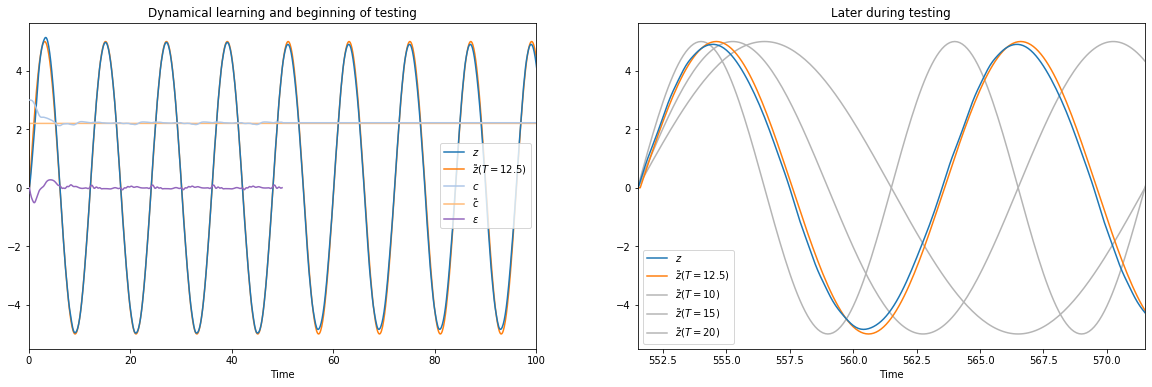

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
learn_steps = int(t_learn/dt)
learntest_times = np.linspace(0, learntest_t, int(learntest_t/dt)+1)
plt.plot(learntest_times, states_learntest_rec['z'][0], label='$z$', c=cmap(0), zorder=1)
plt.plot(learntest_times, tars_learntest[0][0], label=r'$\tilde{{z}}(T={})$'.format(learntest_period[0]), c=cmap(2), zorder=0)
plt.plot(learntest_times, states_learntest_rec['c'][0], label='$c$', c=cmap(1), zorder=3)
plt.plot(learntest_times, tars_learntest[1][0], label=r'$\tilde{c}$', c=cmap(3), zorder=2)
plt.plot(learntest_times[:learn_steps], states_learntest_rec['eps'][0][:learn_steps], label=r'$\varepsilon$', c=cmap(8), zorder=4)
plt.legend().set_zorder(100)
plt.xlim(0, 100)
plt.xlabel('Time')
plt.title('Dynamical learning and beginning of testing')

plt.subplot(122)
z_list = states_learntest_rec['z'][0]
off = t_learn + (t_test-t_learn)/2
found_start = False
while not found_start:
    z0 = z_list[int(off/dt)]
    z1 = z_list[int(off/dt)+1]
    if abs(z0)<0.05 and z1>z0:
        found_start = True
    else:
        off = off+dt

plt.plot(learntest_times, z_list, label='$z$', c=cmap(0), zorder=2)
plt.plot(learntest_times + off, tars_learntest[0][0], label=r'$\tilde{{z}}(T={})$'.format(learntest_period[0]), c=cmap(2), zorder=1)
for tar in pretrain_periods:
    plt.plot(learntest_times + off, tar_func(tar, learntest_times)[0], label=r'$\tilde{{z}}(T={})$'.format(tar), c=plt.get_cmap('Greys')(0.4), zorder=0)
plt.legend().set_zorder(100)
plt.xlim(off, off + 2*10)
plt.xlabel('Time')
plt.title('Later during testing')
plt.show()